In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pandas as pd

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

from matplotlib.colorbar import ColorbarBase

In [3]:
import cmocean

In [81]:
from config import P2EvaluationEmulator

In [4]:
import graphufs
from graphufs.spatialmap import SpatialMap
plt.style.use("graphufs.plotstyle")

/work/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [7]:
ds = xr.open_zarr("/p1-evaluation/p2/long-forecasts/graphufs.2019-01-01T03.2019-12-31T21.zarr/")

In [67]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)
rds = rds[list(x for x in list(ds.data_vars)+["hgtsfc_static"] if x in rds)]
rds = rds.rename({
    "pfull": "level",
    "grid_yt": "lat",
    "grid_xt": "lon",
})

In [68]:
from graphufs.fvemulator import fv_vertical_regrid 

In [71]:
rds = fv_vertical_regrid(rds.rename({"level":"pfull"}), interfaces=list(P2EvaluationEmulator.interfaces))

In [73]:
rds = rds.rename({"pfull": "level"})

In [74]:
rds = rds.sel(time=ds.time.values)

### MAE

In [75]:
ff = ds[["tmp2m", "ugrd10m"]]
tr = rds[["tmp2m", "ugrd10m"]]

In [76]:
mae = np.abs(ff - tr).mean(["lat", "lon"])

/work/Tim.Smith/miniconda3/envs/graphufs-cpu/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(


In [82]:
mae.load();

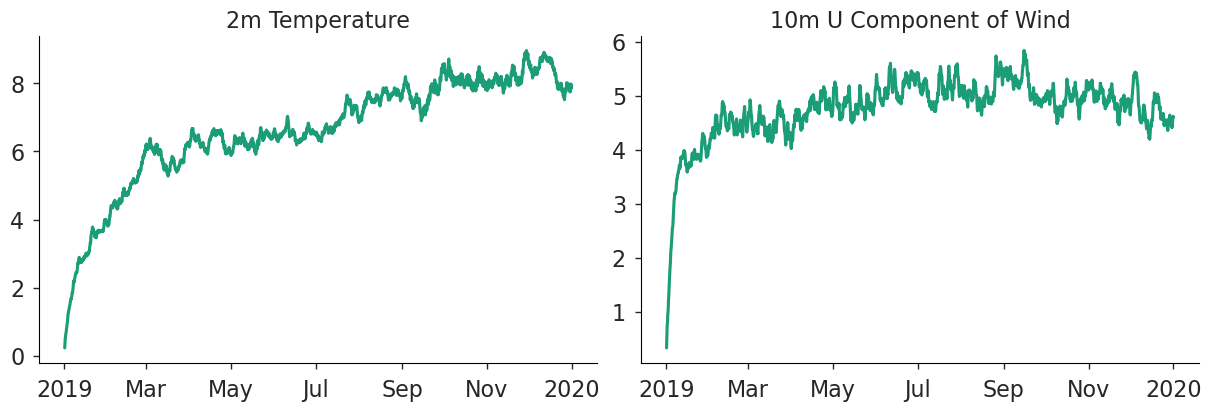

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

for key, label, ax in zip(
    ["tmp2m", "ugrd10m"],
    ["2m Temperature", "10m U Component of Wind"],
    axs,
):
    mae[key].plot(ax=ax)
    ax.set(title=label, ylabel="", xlabel="")

## Plot vs ERA5

In [8]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        ds.time.isel(time=0).values,
        ds.time.isel(time=-1).values
    ),
    level=[250,500,850],
)

In [9]:
mapper = SpatialMap()

In [10]:
ds["10m_wind_speed"] = np.sqrt(ds["ugrd10m"]**2 + ds["vgrd10m"]**2)
era["10m_wind_speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

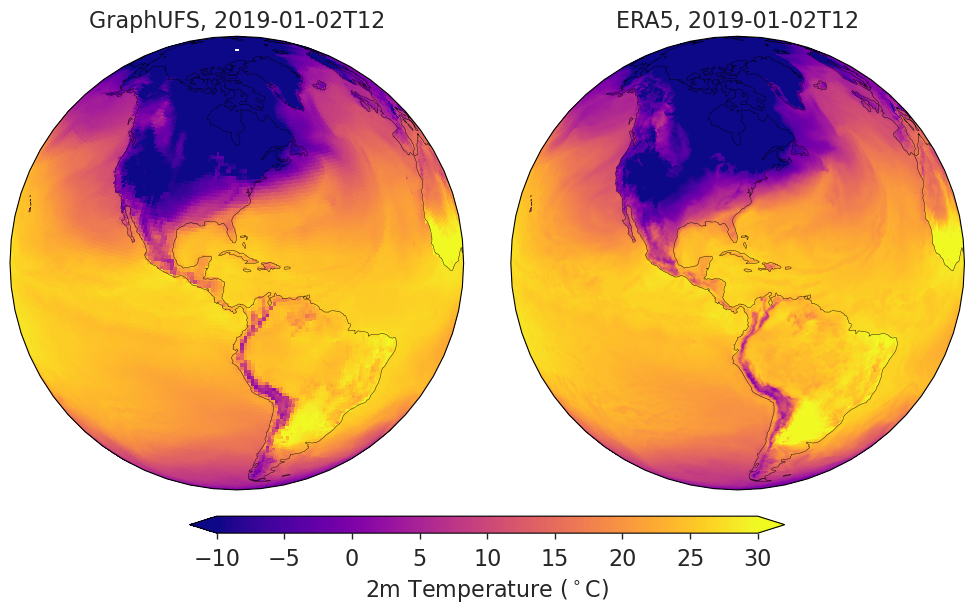

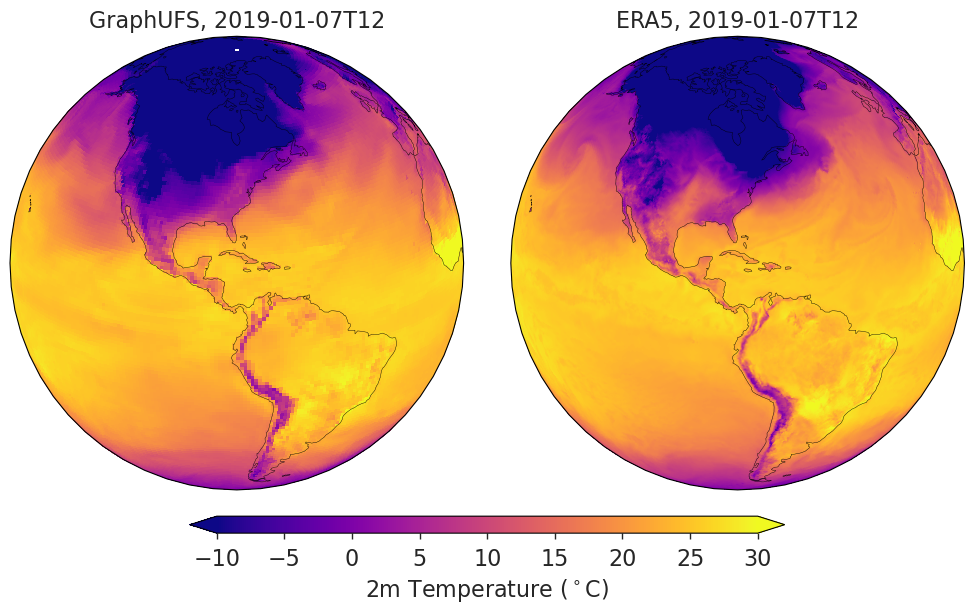

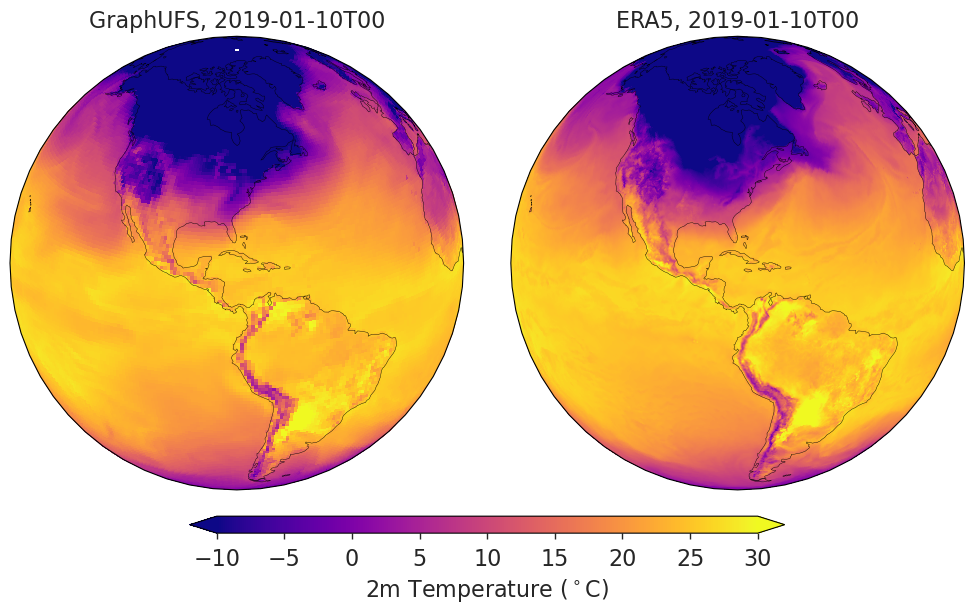

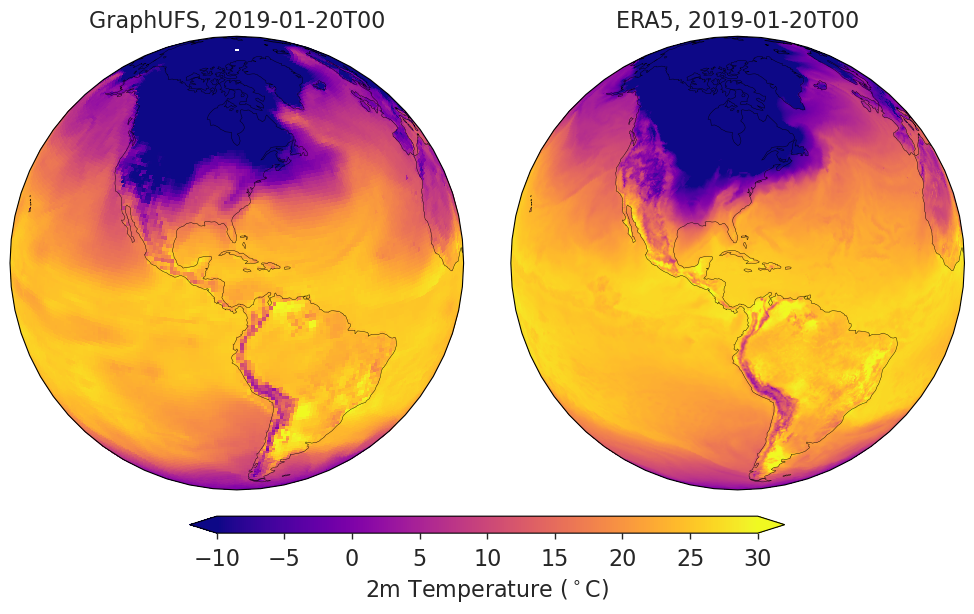

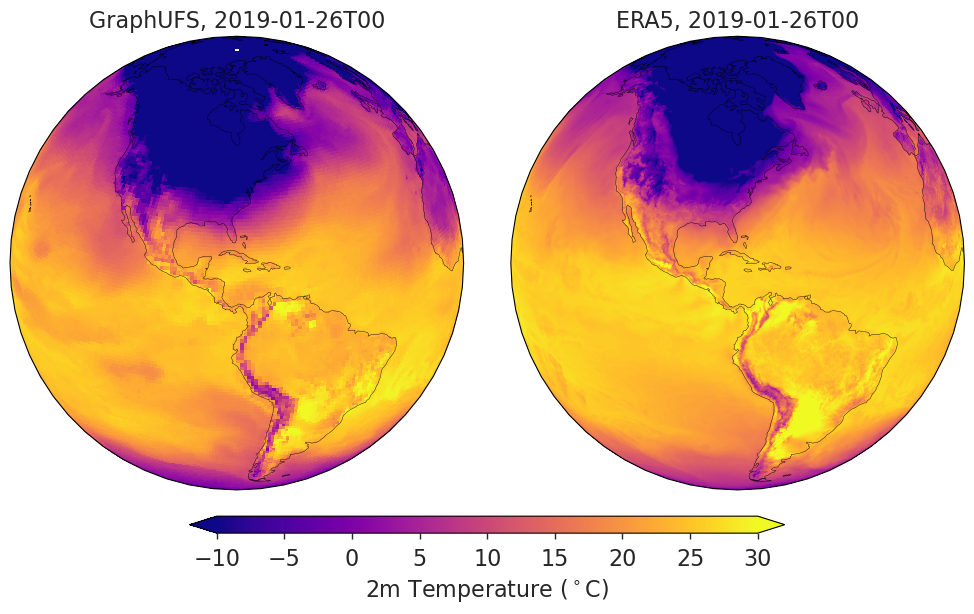

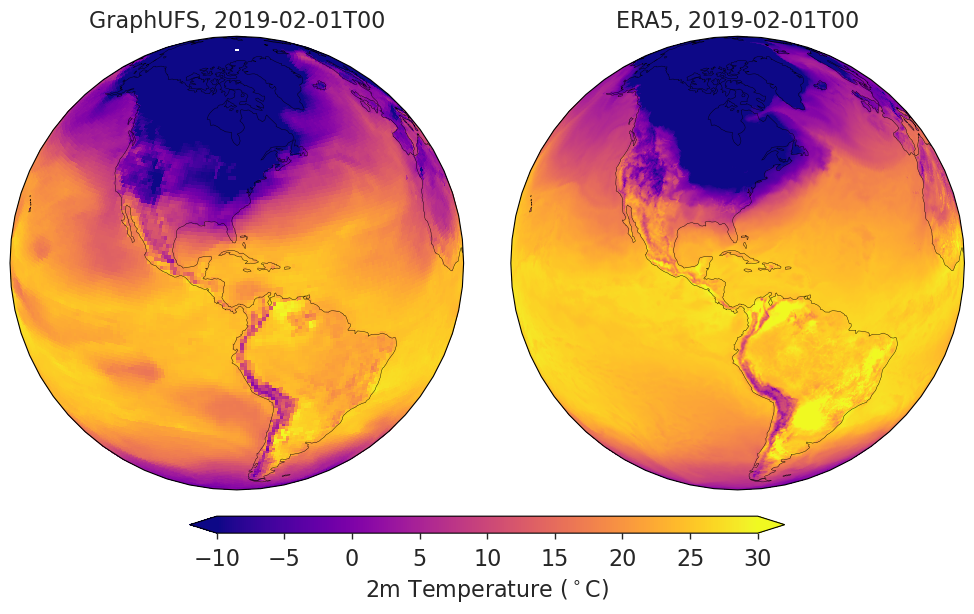

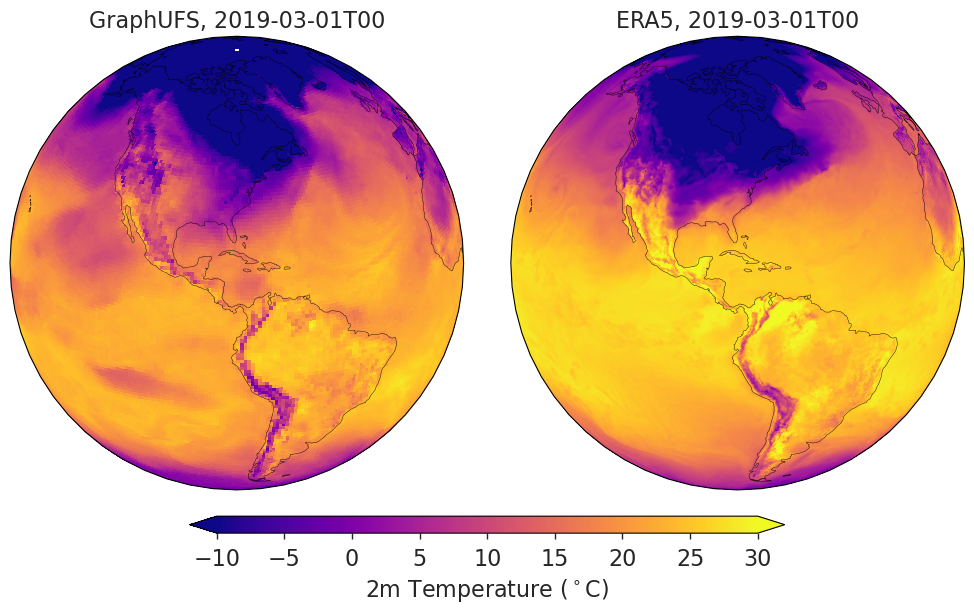

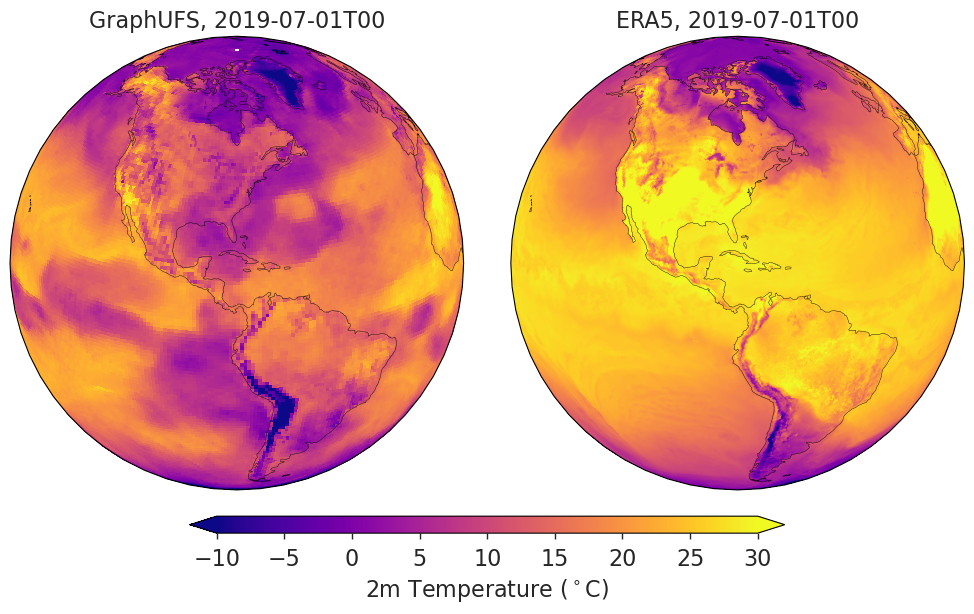

In [11]:
dates = [
    "2019-01-02T12",
    "2019-01-07T12",
    "2019-01-10T00",
    "2019-01-20T00",
    "2019-01-26T00",
    "2019-02-01T00",
    "2019-03-01T00",
    "2019-07-01T00",
]

for date in dates:
    fig, axs = mapper.plot(
        ds["tmp2m"].sel(time=date),
        era["2m_temperature"].sel(time=[date]),
        cmap="plasma",
    );
    fig.savefig(f"figures/long_forecast_tmp2m_{date}.jpeg", bbox_inches="tight", dpi=300)

## Plot 2m Temperature and Geopotential as a function of latitude

In [19]:
from ufs2arco import Layers2Pressure


In [15]:
mds = xr.open_zarr(P2EvaluationEmulator.norm_urls["mean"], storage_options={"token": "anon"})

In [32]:
for key in ["ak", "bk"]:
    ds[key] = mds[key]
    ds = ds.set_coords(key)

In [24]:
lp = Layers2Pressure(ak=mds["ak"].values, bk=mds["bk"].values, level_name="level")

In [25]:
ds["delz"] = lp.calc_delz(ds["pressfc"], ds["tmp"], ds["spfh"])

In [33]:
ds["geopotential"] = lp.calc_geopotential(hgtsfc=rds["hgtsfc_static"], delz=ds["delz"])

In [35]:
prsl = lp.calc_layer_mean_pressure(ds["pressfc"], ds["tmp"], ds["spfh"], ds["delz"])

In [37]:
p = 500
cds = lp.get_interp_coefficients(p*100, prsl)

In [41]:
%%time
cds.load();

CPU times: user 3min 4s, sys: 35.9 s, total: 3min 40s
Wall time: 49.5 s


In [43]:
%%time
z500 = lp.interp2pressure(ds["geopotential"], p*100, prsl, cds)

CPU times: user 1min 9s, sys: 8.98 s, total: 1min 18s
Wall time: 1min 18s


In [ ]:
%%time
z500.load();

In [51]:
era = era.rename({"latitude": "lat", "longitude": "lon"})

In [57]:
ds.tmp2m.load();

[Text(0, 0.5, 'Latitude'), Text(0.5, 0, ''), Text(0.5, 1.0, '2m Temperature')]

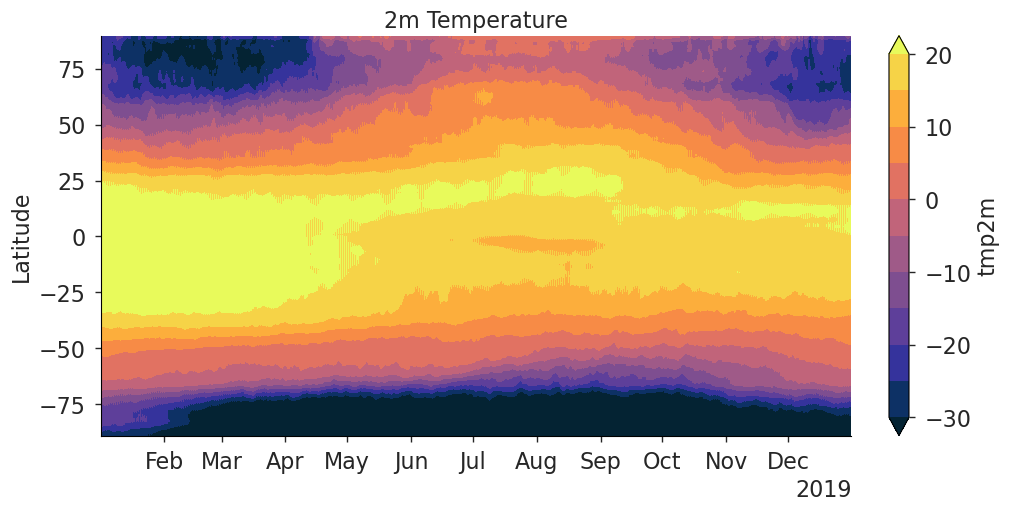

In [89]:
fig, ax = plt.subplots(1,1,figsize=(10,5), constrained_layout=True)
plotme = (ds.tmp2m.squeeze().mean("lon"))
plotme = plotme-273.15
plotme.plot.contourf(x="time", vmin=-30, vmax=20, ax=ax, cmap="cmo.thermal", levels=11)
ax.set(ylabel="Latitude", xlabel="", title="2m Temperature")

In [96]:
ez500 = era.geopotential.sel(level=500).isel(lon=slice(None, None, 4), lat=slice(None, None, 4))

In [98]:
ez500.load();

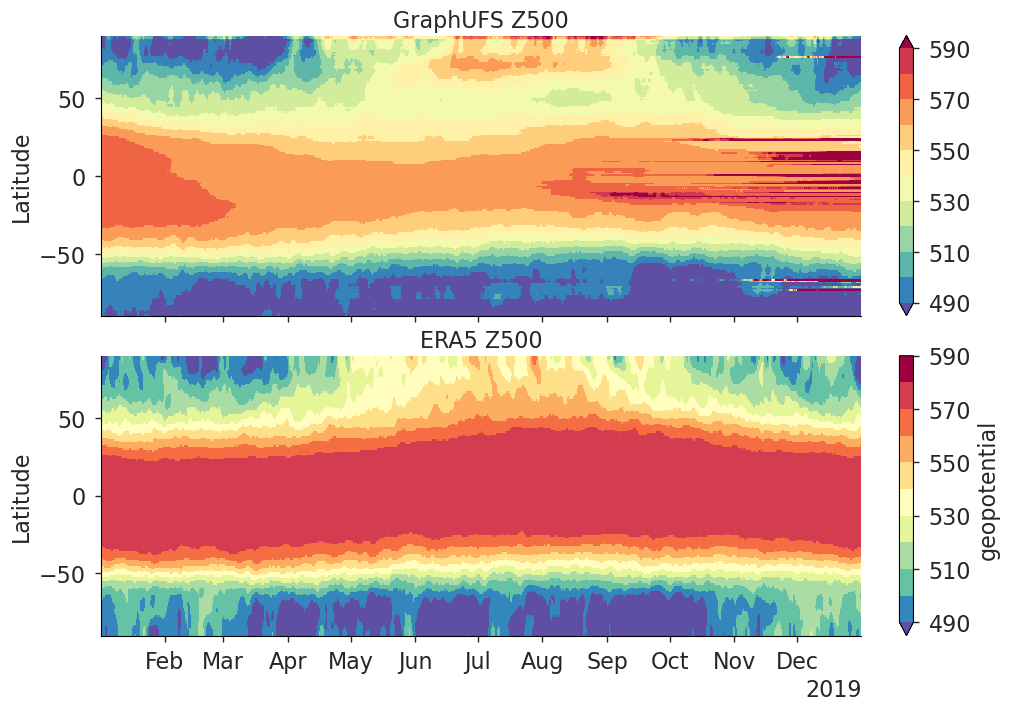

In [122]:
fig, axs = plt.subplots(2, 1, figsize=(10,7), constrained_layout=True, sharex=True)

for xda, title, ax in zip([z500, ez500], ["GraphUFS Z500", "ERA5 Z500"], axs):

    plotme = xda.mean("lon").squeeze()
    plotme = plotme / 100
    plotme.plot(ax=ax, x="time", cmap="Spectral_r", vmin=490, vmax=590, levels=11 )
    ax.set(xlabel="", ylabel="Latitude", title=title)
 
fig.savefig(f"figures/long_forecast_z500_lat.jpeg", bbox_inches="tight", dpi=300)

In [101]:
%%time
et2m = era["2m_temperature"].isel(lon=slice(None, None, 4), lat=slice(None, None, 4))
et2m.load();

CPU times: user 49.3 s, sys: 14.9 s, total: 1min 4s
Wall time: 1min 21s


In [106]:
%%time
rt2m = rds.tmp2m
rt2m.load();

CPU times: user 4.92 s, sys: 1.55 s, total: 6.47 s
Wall time: 16.2 s


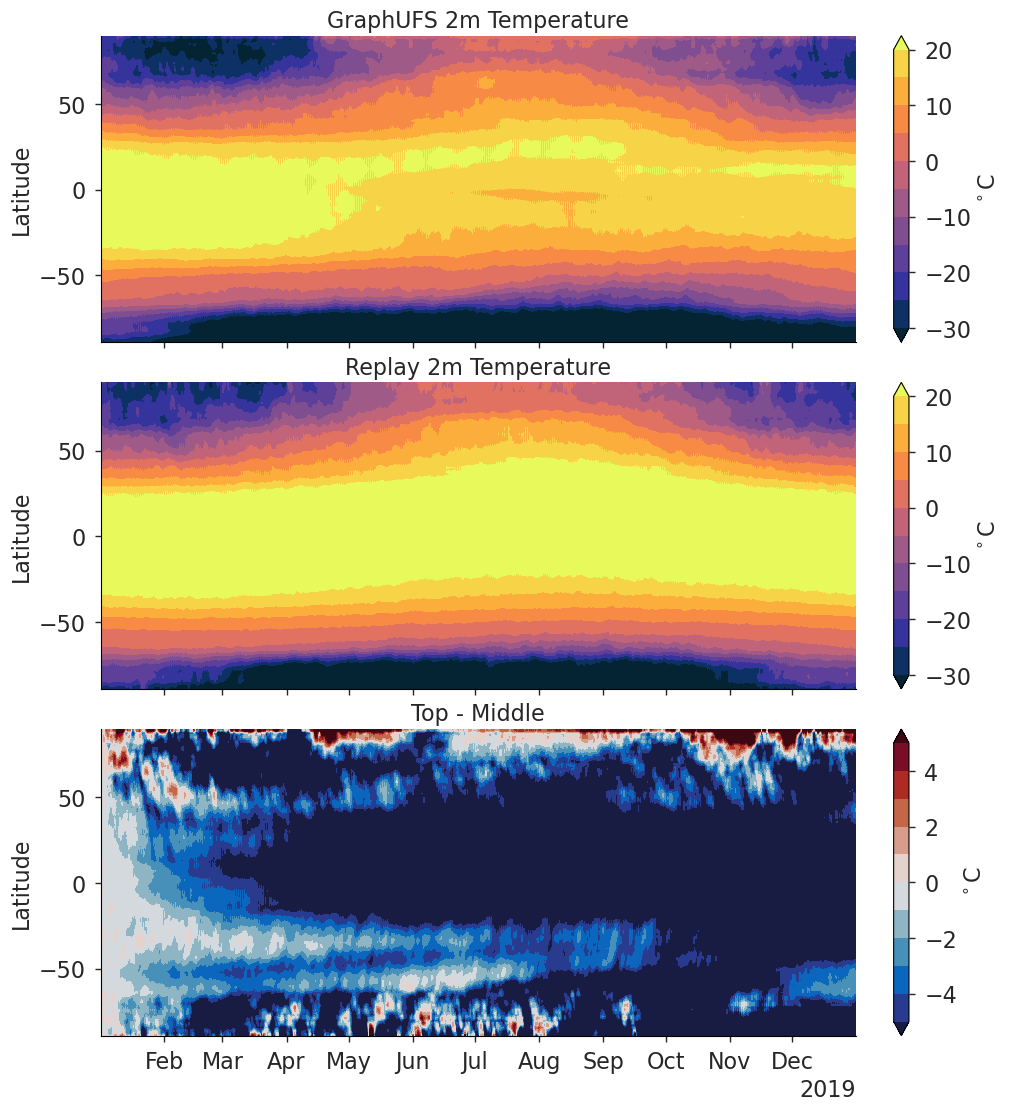

In [119]:
fig, axs = plt.subplots(3, 1, figsize=(10,11), constrained_layout=True, sharex=True)

for xda, title, ax in zip([ds.tmp2m, rt2m], ["GraphUFS 2m Temperature", "Replay 2m Temperature"], axs):

    plotme = xda.mean("lon").squeeze()
    plotme = plotme - 273.15
    plotme.plot.contourf(ax=ax, x="time", cmap="cmo.thermal", vmin=-30, vmax=20, levels=11, cbar_kwargs={"label": r"$^\circ$C"})
    ax.set(xlabel="", ylabel="Latitude", title=title)
    
plotme = ds.tmp2m.mean("lon").squeeze() - rt2m.mean("lon").squeeze()
plotme.plot.contourf(ax=axs[-1], x="time", cmap="cmo.balance", levels=11, vmin=-5, vmax=5, cbar_kwargs={"label": r"$^\circ$C"})
axs[-1].set(xlabel="", ylabel="Latitude", title="Top - Middle")
fig.savefig(f"figures/long_forecast_tmp2m_lat.jpeg", bbox_inches="tight", dpi=300)

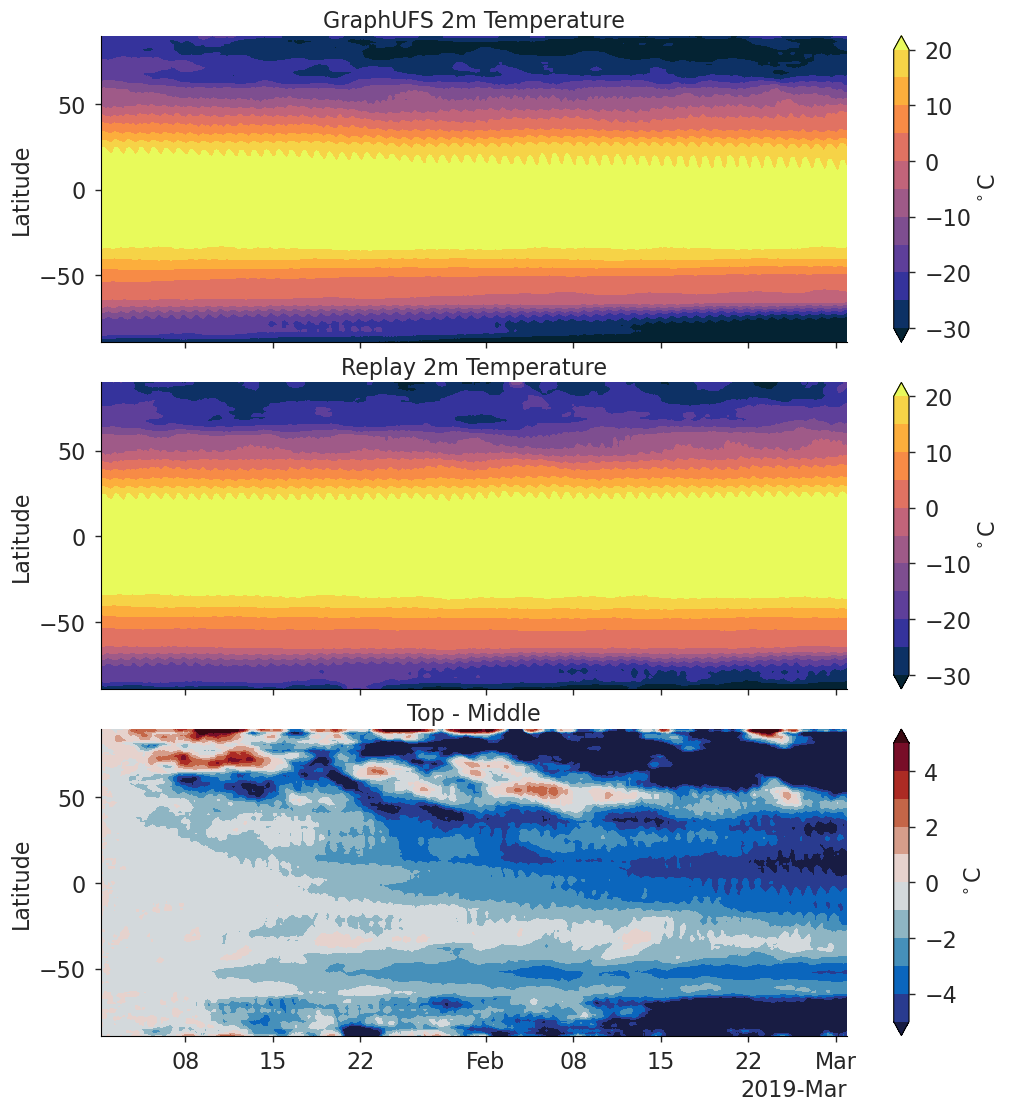

In [120]:
fig, axs = plt.subplots(3, 1, figsize=(10,11), constrained_layout=True, sharex=True)

for xda, title, ax in zip([ds.tmp2m, rt2m], ["GraphUFS 2m Temperature", "Replay 2m Temperature"], axs):

    plotme = xda.mean("lon").squeeze()
    plotme = plotme - 273.15
    plotme = plotme.sel(time=slice(None, "2019-03-01"))
    plotme.plot.contourf(ax=ax, x="time", cmap="cmo.thermal", vmin=-30, vmax=20, levels=11, cbar_kwargs={"label": r"$^\circ$C"})
    ax.set(xlabel="", ylabel="Latitude", title=title)
    
plotme = ds.tmp2m.mean("lon").squeeze() - rt2m.mean("lon").squeeze()
plotme = plotme.sel(time=slice(None, "2019-03-01"))
plotme.plot.contourf(ax=axs[-1], x="time", cmap="cmo.balance", levels=11, vmin=-5, vmax=5, cbar_kwargs={"label": r"$^\circ$C"})
axs[-1].set(xlabel="", ylabel="Latitude", title="Top - Middle")
fig.savefig(f"figures/long_forecast_tmp2m_lat_zoom.jpeg", bbox_inches="tight", dpi=300)